# Code to evaluate continuity budgets in NeverWorld2

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = "Latin Modern Roman"
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

The continuity equation (for a given layer) is
\begin{align} 
\partial_t h_C + \nabla\cdot \left( h \mathbf{u} \right)_C  = 0 \;,
\end{align}

where the subscript $C$ denotes coarsened variables. The time average of the above equation is
\begin{align}
    h_C \vert_0^\tau \tau^{-1} + \nabla\cdot \langle \left( h \mathbf{u} \right)_C \rangle  = 0\;.
\end{align}

The second term simplifies to 

\begin{align}
    \langle h u \rangle_C[i,j] = \sum_{n=1}^{N} \langle hu \rangle[iN,(j-1)N+n]
    = \sum_{n=1}^{N} \langle h_C \rangle \langle u_C \rangle + \langle h_C \rangle \langle u_P \rangle + \langle h_P \rangle \langle u_C \rangle + \langle h_P \rangle \langle u_P \rangle 
    + \langle h^\dagger u^\dagger \rangle
    \; ,
\end{align}

where the terms on RHS are evaluated at grid point $[iN,(j-1)N+n]$. Subscript $P$ refers to the fine-scale fluctuations in space (e.g. $h_P \equiv h - h_C$), whereas the subscript $\dagger$ refers to fluctuations in time (e.g. $h^\dagger \equiv h - \langle h_k \rangle $). The time-average ($\langle \cdot \rangle $) is defined over a time $\tau$, where $\langle \cdot \rangle = {1}/{\tau} \int_0^\tau \cdot \;\mathrm{d}t$, and the last term is defined as
\begin{align}
    \langle h^\dagger \mathbf{u}^\dagger \rangle
    &=  \langle {h}{\mathbf{u}} \rangle -  \langle {h} \rangle \langle {\mathbf{u}} \rangle\;.
    \label{eqn:hdagudag}
\end{align}


 Coarsening applied to $h$ is (temporarily dropping $k$ subscript)
\begin{align}
    h_C[i,j] &= \frac{1}{N^2} \sum_{m=1}^{N} \sum_{n=1}^{N} h[(i-1)N+m,(j-1)N+n]\;.
\end{align}

We can similarly coarsen $hu$ as
\begin{align}
    (hu)_C[i,j] &= \sum_{n=1}^{N} (hu)[iN,(j-1)N+n] \\
    &= \frac{1}{N} \sum_{n=1}^{N} h_C u_C + h_P u_C + h_C u_P + h_P u_P
    \; .
    \label{eqn:hu_space}
\end{align}


Hereon, we define 7 terms to evaluate the budget:

Term 1: $h_C \vert_0^\tau \tau^{-1}$

Term 2: $\nabla\cdot\left(\sum_{n=1}^{N}\langle h_C \rangle \langle \mathbf{u}_C \rangle\right)$

Term 3: $\nabla\cdot\left(\sum_{n=1}^{N}\langle h_C \rangle \langle \mathbf{u}_P \rangle\right)$

Term 4: $\nabla\cdot\left(\sum_{n=1}^{N} \langle h_P \rangle \langle \mathbf{u}_C \rangle \right)$

Term 5: $\nabla\cdot\left(\sum_{n=1}^{N}\langle h_P \rangle \langle \mathbf{u}_P \rangle\right)$

Term 6: $\nabla\cdot\left(\sum_{n=1}^{N}\langle {h^\dagger}{\mathbf{u}^\dagger} \rangle \rangle\right)$

<!-- Term 7: $-\nabla\cdot\left(\sum_{n=1}^{N}\langle {h} \rangle \langle {\mathbf{u}} \rangle\right)$ -->



In [3]:
tau = 500*86400 # seconds
end_time = 29500
start_time = end_time - tau/86400
coarsen = 2
layer_no = 4

In [4]:
try:
    s0 = xr.open_dataset('snapshots_000%i.nc' % (start_time-500+5), decode_times=False)
except:
    s0 = xr.open_dataset('snapshots_000%i.nc' % (end_time-500+5), decode_times=False)
    
s1 = xr.open_dataset('snapshots_000%i.nc' % (end_time-500+5), decode_times=False)
av = xr.open_dataset('averages_000%i.nc' % (end_time-500+2), decode_times=False)
st = xr.open_dataset('static.nc', decode_times=False)
lm = xr.open_dataset('longmean_00028250.nc', decode_times=False)

In [5]:
st

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * time         (time) float64 0.0
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables:
    geolon       (yh, xh) float64 ...
    geolat       (yh, xh) float64 ...
    geolon_c     (yq, xq) float32 ...
    geolat_c     (yq, xq) float32 ...
    geolon_u     (yh, xq) float32 ...
    geolat_u     (yh, xq) float32 ...
    geolon_v     (yq, xh) float32 ...
    geolat_v     (yq, xh) float32 ...
    area_t       (yh, xh) float64 ...
    area_u       (yh, xq) float64 ...
    area_v       (yq, xh) float64 ...
    dyCu         (yh, xq) float64 ...
    dxCv         (yq, xh) float64 ...
    dxCu         (yh, xq) float64 ...
    dyCv         (yq, xh) float64 ...
    depth_ocean  (yh, xh) float32 ...
    wet          (yh, xh) float64 ...
    wet_c        (yq, xq) float32 ...
    wet_u        (yh, xq) float32 ...
    wet_v        (yq, xh) float32 ...
    Coriolis     (yq, xq) float32 ...
Attributes:
    filename:   static.nc
    title:      NeverWorld2
    grid_type:  regular
    grid_tile:  N/A

## Coarsening

The values of velocity need to be interpolated from the short-time averages as $\mathbf{u} = \langle \mathbf{u}h \rangle/\langle h\rangle$.

In [6]:
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    n,layers,ly,lx = h.shape
    h_at_u = np.zeros((n,layers,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    n,layers,ly,lx = h.shape
    h_at_v = np.zeros((n,layers,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

# h_at_u = grid.interp(av.h, axis='X',boundary='fill') # m
h_at_u = interp_h_to_u(av.h.values.astype(float)) # m
u_eff = (av.uh.astype(float))/(h_at_u + 1e-20) # m^2/s (divide by st.dyCu to get the right units)
u_lm = lm.u.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

# h_at_v = grid.interp(av.h, axis='Y',boundary='fill') # m
h_at_v = interp_h_to_v(av.h.values.astype(float))
v_eff = (av.vh.astype(float))/(h_at_v + 1e-20) # m^2/s (divide by st.dxCv to get the right units)
v_lm = lm.v.sel(time=slice(start_time,end_time)).values[:,layer_no].astype(float).mean(axis=0)

h_temp = av.h.sel(time=slice(start_time,end_time)).astype(float) # m
uh_temp = av.uh.sel(time=slice(start_time,end_time)).astype(float) # m^3/s
vh_temp = av.vh.sel(time=slice(start_time,end_time)).astype(float) # m^3/s
u_temp = u_eff.sel(time=slice(start_time,end_time)) # m^2/s
v_temp = v_eff.sel(time=slice(start_time,end_time)) # m^2/s

time = av.time.sel(time=slice(start_time,end_time)) 
h_fine = h_temp[:,layer_no].mean(axis=0) # m
uh_fine = uh_temp[:,layer_no].mean(axis=0) # m^3/s
vh_fine = vh_temp[:,layer_no].mean(axis=0) # m^3/s
u_fine = u_temp[:,layer_no].mean(axis=0) # m^2/s
v_fine = v_temp[:,layer_no].mean(axis=0) # m^2/s

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


A comparison of the effective and diagnosed velocities is shown below.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


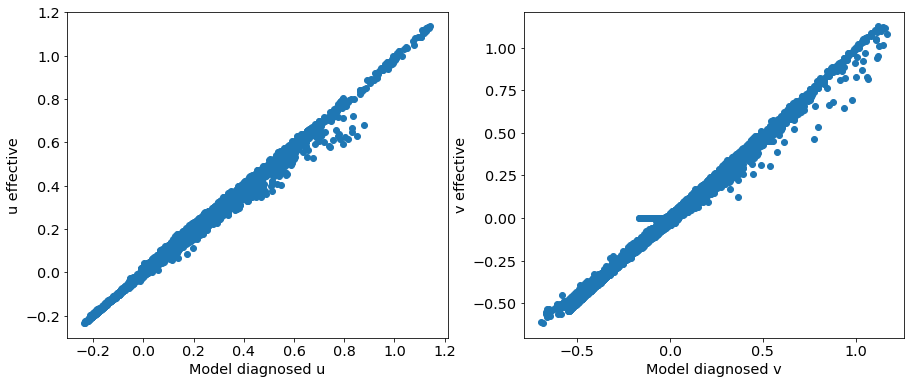

In [7]:
u1 = u_lm
u2 = u_fine.values/st.dyCu

v1 = v_lm
v2 = v_fine.values/st.dxCv

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(u1,u2)
# plt.plot([-np.nanmin(u1),np.nanmax(u1)],[-np.nanmin(u1),np.nanmax(u1)],'k-')
plt.xlabel('Model diagnosed u')
plt.ylabel('u effective')

plt.subplot(1,2,2)
plt.scatter(v1,v2)
# plt.plot([-np.nanmin(v1),np.nanmax(v1)],[-np.nanmin(v1),np.nanmax(v1)],'k-')
plt.xlabel('Model diagnosed v')
plt.ylabel('v effective')

plt.savefig('scatter_u_layer_%i_start_time_%i_days_tau_%i_days.png' % (layer_no,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)

All parameters are defined either on the fine grid (indicated by subscript $\texttt{fine}$) or on the coarse grid (indicated by subscript $\texttt{coarse}$). The coarsened version of $h$ ($\equiv\texttt{h}_\texttt{fine}$) is indicated by $\texttt{hc}_\texttt{coarse}$, defined on the coarse grid by definition, but it can be interpolated onto the fine grid to define ($\texttt{hc}_\texttt{fine}$). This is necessary to estimate the fine-scale fluctuations $\texttt{hp}_\texttt{fine}=\texttt{h}_\texttt{fine} - \texttt{hc}_\texttt{fine}$, defined on the fine grid by definition.

In [8]:
def coarsen_h(h_fine):
    """It returns the 4 cell average of h when coarsen = 2"""
    ly,lx = h_fine.shape 
    hc_coarse = np.zeros((ly//coarsen,lx//coarsen))
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[:,:] = hc_coarse[:,:] + h_fine[j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

def project_h_to_fine(h_coarse):
    """It projects hc_coarse onto the fine grid"""
    ly_coarsen,lx_coarsen = h_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*lx_coarsen
    hc_fine = np.zeros((ly,lx))
    
    # Projecting hc_coarse onto the fine grid 
    for j in range(coarsen):
        for i in range(coarsen):
            hc_fine[j::coarsen,i::coarsen] = hc_coarse[:,:] 
   
    return hc_fine

def coarsen_u(u_fine):
    """It returns the mean over j"""
    ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:] = uc_coarse[:,:] + u_fine[j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_hu(uh_fine):
    """It returns the sum over j"""
    ly,lx_p_1 = uh_fine.shape 
    lx = lx_p_1 - 1
    uhc_coarse = np.zeros((ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uhc_coarse[:,:] = uhc_coarse[:,:] + uh_fine[j::coarsen,::coarsen]
    
    return uhc_coarse

def project_u_to_fine(u_coarse):
    """It projects uc_coarse onto the fine grid"""
    ly_coarsen,lx_coarsen_p_1 = u_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*(lx_coarsen_p_1-1)
    uc_fine = np.zeros((ly,lx//coarsen+1))
    
    # Projecting onto the fine grid 
    for j in range(coarsen):
        uc_fine[j::coarsen,:] = u_coarse[:,:]
        
    return uc_fine

def coarsen_v(v_fine):
    """It returns the mean over i"""
    ly_p_1,lx = v_fine.shape 
    ly = ly_p_1 - 1
    vc_coarse = np.zeros((ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vc_coarse[:,:] = vc_coarse[:,:] + v_fine[::coarsen,i::coarsen]
    
    return vc_coarse/coarsen

def coarsen_hv(vh_fine):
    """It returns the sum over i"""
    ly_p_1,lx = vh_fine.shape 
    ly = ly_p_1 - 1
    vhc_coarse = np.zeros((ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vhc_coarse[:,:] = vhc_coarse[:,:] + vh_fine[::coarsen,i::coarsen]
    
    return vhc_coarse

def project_v_to_fine(v_coarse):
    """It projects vc_coarse onto the fine grid"""
    ly_coarsen_p_1,lx_coarsen = v_coarse.shape 
    ly,lx = coarsen*(ly_coarsen_p_1-1),coarsen*lx_coarsen
    vc_fine = np.zeros((ly//coarsen+1,lx))
    
    # Projecting onto the fine grid 
    for i in range(coarsen):
        vc_fine[:,i::coarsen] = v_coarse[:,:]
        
    return vc_fine

def interp_h_to_u(h):
    """Interpolate h to the grid points where u is defined"""
    ly,lx = h.shape
    h_at_u = np.zeros((ly,lx+1))
    h_at_u[:,1:-1] = (h[:,:-1] + h[:,1:])/2
    h_at_u[:,0] = (h[:,0] + h[:,-1])/2 # periodic
    h_at_u[:,-1] = (h[:,0] + h[:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    """Interpolate h to the grid points where v is defined"""
    ly,lx = h.shape
    h_at_v = np.zeros((ly+1,lx))
    h_at_v[1:-1,:] = (h[:-1,:] + h[1:,:])/2
    h_at_v[0,:] = h[0,:] # non-periodic
    h_at_v[-1,:] = h[-1,:] # non-periodic
    
    return h_at_v
    
def calc_hc_uc(hc,uc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    uc_fine = project_u_to_fine(uc_coarse)
    
    return h_at_u[:,::coarsen]*uc_fine

def calc_hc_up(hc_coarse,up):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    
    return h_at_u[:,::coarsen]*up

def calc_hp_uc(hp,uc_coarse):
    uc_fine = project_u_to_fine(uc_coarse)
    h_at_u = interp_h_to_u(hp)
    
    return h_at_u[:,::coarsen]*uc_fine

def calc_hp_up(hp,up):
    h_at_u = interp_h_to_u(hp)
    
    return h_at_u[:,::coarsen]*up

def calc_hc_vc(hc,vc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_v = interp_h_to_v(hc_fine)
    vc_fine = project_v_to_fine(vc_coarse)
    
    return h_at_v[::coarsen,:]*vc_fine

def calc_hc_vp(hc_coarse,vp):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_v = interp_h_to_v(hc_fine)
    
    return h_at_v[::coarsen,:]*vp

def calc_hp_vc(hp,vc_coarse):
    vc_fine = project_v_to_fine(vc_coarse)
    h_at_v = interp_h_to_v(hp)
    
    return h_at_v[::coarsen,:]*vc_fine

def calc_hp_vp(hp,vp):
    h_at_v = interp_h_to_v(hp)
    
    return h_at_v[::coarsen,:]*vp


hc_coarse = coarsen_h(h_fine) # m
hc_fine = project_h_to_fine(hc_coarse) # m
hp_fine = h_fine - hc_fine # m

uc_coarse = coarsen_u(u_fine) # m^2/s
uc_fine = project_u_to_fine(uc_coarse) # m^2/s
up_fine = u_fine[:,::coarsen] - uc_fine # m^2/s

uhc_coarse = coarsen_hu(uh_fine) # m^3/s
uhc_fine = project_u_to_fine(uhc_coarse) # m^3/s

vc_coarse = coarsen_v(v_fine) # m^2/s
vc_fine = project_v_to_fine(vc_coarse) # m^2/s
vp_fine = v_fine[::coarsen,:] - vc_fine # m^2/s

vhc_coarse = coarsen_hv(vh_fine) # m^3/s
vhc_fine = project_v_to_fine(vhc_coarse) # m^3/s

hcuc_semi_fine = calc_hc_uc(hc_coarse,uc_coarse) # m^3/s
hcup_semi_fine = calc_hc_up(hc_coarse,up_fine) # m^3/s
hpuc_semi_fine = calc_hp_uc(hp_fine.values,uc_coarse) # m^3/s
hpup_semi_fine = calc_hp_up(hp_fine.values,up_fine) # m^3/s

hcvc_semi_fine = calc_hc_vc(hc_coarse,vc_coarse) # m^3/s
hcvp_semi_fine = calc_hc_vp(hc_coarse,vp_fine) # m^3/s
hpvc_semi_fine = calc_hp_vc(hp_fine.values,vc_coarse) # m^3/s
hpvp_semi_fine = calc_hp_vp(hp_fine.values,vp_fine) # m^3/s

def sum_j_direction(hu):
    ly,lx_p_1 = hu.shape 
    lx = lx_p_1 - 1
    hu_coarse = np.zeros((ly//coarsen,lx+1))
    
    for j in range(coarsen):
        hu_coarse[:,:] = hu_coarse[:,:] + hu[j::coarsen,:]
    
    return hu_coarse

def sum_i_direction(hv):
    ly_p_1,lx = hv.shape 
    ly = ly_p_1 - 1
    hv_coarse = np.zeros((ly+1,lx//coarsen))
    
    for i in range(coarsen):
        hv_coarse[:,:] = hv_coarse[:,:] + hv[:,i::coarsen]
    
    return hv_coarse


hcup = sum_j_direction(hcup_semi_fine) # m^3/s
hpuc = sum_j_direction(hpuc_semi_fine) # m^3/s
hpup = sum_j_direction(hpup_semi_fine) # m^3/s
hcuc = sum_j_direction(hcuc_semi_fine) # m^3/s

hcvp = sum_i_direction(hcvp_semi_fine) # m^3/s
hpvc = sum_i_direction(hpvc_semi_fine) # m^3/s
hpvp = sum_i_direction(hpvp_semi_fine) # m^3/s
hcvc = sum_i_direction(hcvc_semi_fine) # m^3/s

hdagudag_fine = uh_fine.values - interp_h_to_u(h_fine.values)*u_fine.values # m^3/s - m*m^2/s
hdagvdag_fine = vh_fine.values - interp_h_to_v(h_fine.values)*v_fine.values # m^3/s - m*m^2/s

hdagudag = coarsen_hu(hdagudag_fine) # m^3/s
hdagvdag = coarsen_hv(hdagvdag_fine) # m^3/s

ly,lx = st.area_t.shape 
areac = st.area_t.values.astype(float).reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).sum(axis=-1).sum(axis=1) # m^2

Note that $h$, $u$, $v$, $hu$ and $hv$ each have different definitions when coarsening

In [9]:
xhc = st.xh.values.reshape(-1,coarsen).mean(axis=1)
yhc = st.yh.values.reshape(-1,coarsen).mean(axis=1)
xqc = st.xq.values[::coarsen]
yqc = st.yq.values[::coarsen]

dsc = xr.Dataset(coords={'xhc': (['xhc',], xhc), 'xqc': (['xqc',], xqc), 'yhc': (['yhc',], yhc), 'yqc': (['yqc',], yqc)})
dsc = dsc.assign_coords({'xhc': ('xhc', xhc), 'xqc': ('xqc', xqc), 'yhc': ('yhc', yhc), 'yqc':('yqc', yqc) }) 
gridc = Grid(dsc, coords={'X': {'center': 'xhc', 'outer': 'xqc'},
                          'Y': {'center': 'yhc', 'outer': 'yqc'} }, periodic=['X'])

dsc = xr.Dataset({'hcuc': (('yhc','xqc'), hcuc), 
                  'hcup': (('yhc','xqc'), hcup), 
                  'hpuc': (('yhc','xqc'), hpuc), 
                  'hpup': (('yhc','xqc'), hpup), 
                  'hdagudag': (('yhc','xqc'), hdagudag), 
                  'hcvc': (('yqc','xhc'), hcvc), 
                  'hcvp': (('yqc','xhc'), hcvp), 
                  'hpvc': (('yqc','xhc'), hpvc), 
                  'hpvp': (('yqc','xhc'), hpvp), 
                  'hdagvdag': (('yqc','xhc'), hdagvdag),
                  'areac': (('yhc','xhc'), areac)})

### Term 1

In [10]:
# m

hc0 = (s0.h.sel(time=start_time).values[layer_no].astype(float).reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).mean(axis=-1).mean(axis=1))
hc1 = (s1.h.sel(time=end_time).values[layer_no].astype(float).reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).mean(axis=-1).mean(axis=1))

In [11]:
# m/s*m^2 = m^3/s
term1 = np.divide((hc1-hc0),tau)*dsc.areac.astype(float)
np.shape(term1)

(280, 120)

### Terms 2-5

In [12]:
# m^3/s

term2 =  (gridc.diff(dsc.hcuc.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hcvc.astype(float), 'Y', boundary='fill')) 
np.shape(term2)

(280, 120)

In [13]:
# m^3/s

term3 =  (gridc.diff(dsc.hcup.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hcvp.astype(float), 'Y', boundary='fill')) 
np.shape(term3)

(280, 120)

In [14]:
# m^3/s

term4 =  (gridc.diff(dsc.hpuc.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hpvc.astype(float), 'Y', boundary='fill') )
np.shape(term4)

(280, 120)

In [15]:
# m^3/s

term5 =  (gridc.diff(dsc.hpup.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hpvp.astype(float), 'Y', boundary='fill') )
np.shape(term5)

(280, 120)

### Term 6

In [16]:
# m^3/s

term6 =  (gridc.diff(dsc.hdagudag.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hdagvdag.astype(float), 'Y', boundary='fill') )
np.shape(term6)

(280, 120)

## Budget

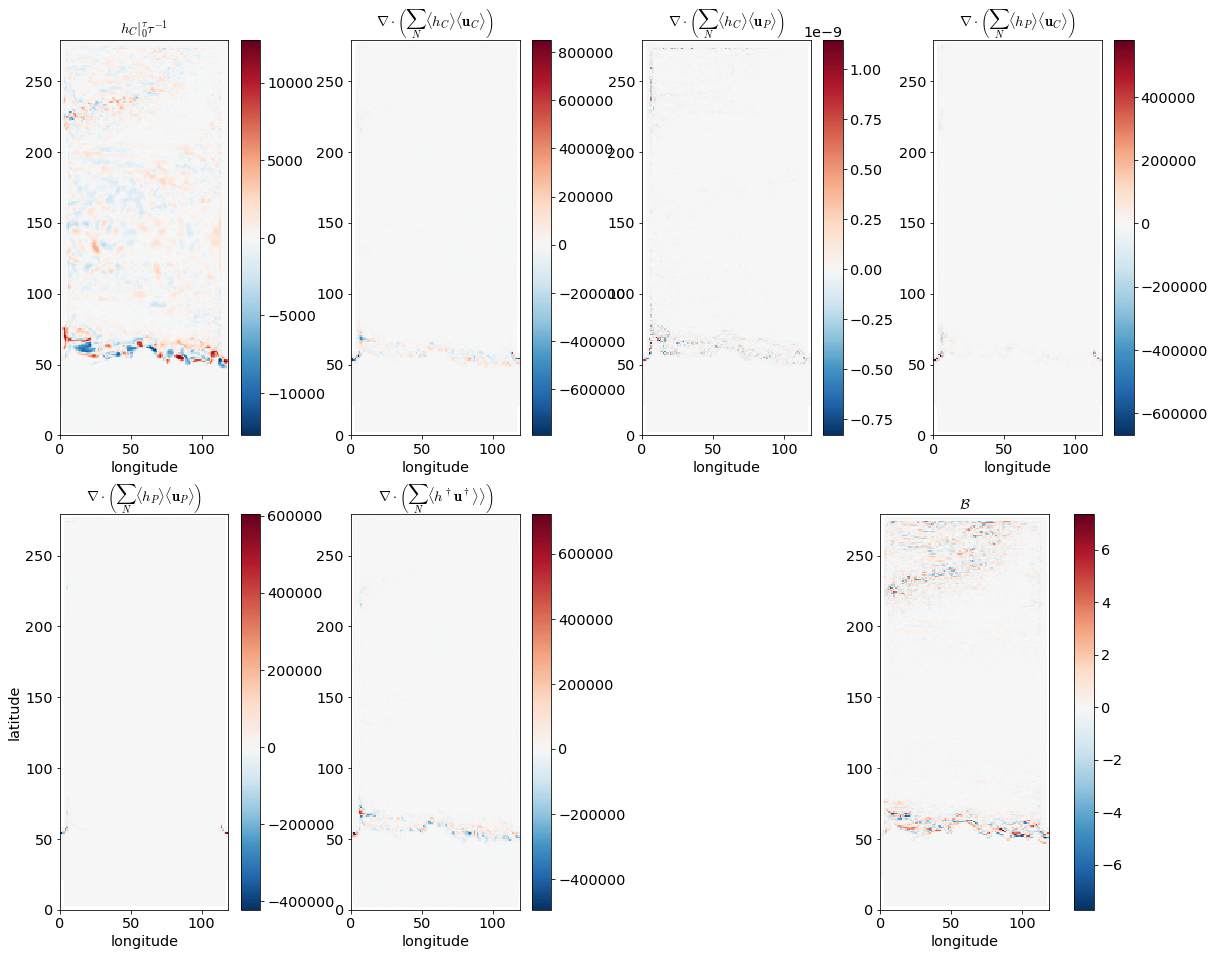

8.644428539995645e-06

In [17]:
budget = term1 + term2 + term3 + term4 + term5 + term6

plt.figure(figsize=(20,16))
plt.subplot(2,4,1)
plt.pcolormesh(dsc.xhc,dsc.yhc,term1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$h_C \vert_0^\tau \tau^{-1}$')
plt.colorbar()

plt.subplot(2,4,2)
plt.pcolormesh(dsc.xhc,dsc.yhc,term2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_C \rangle \langle \mathbf{u}_C \rangle\right) $')
plt.colorbar()

plt.subplot(2,4,3)
plt.pcolormesh(dsc.xhc,dsc.yhc,term3,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_C \rangle \langle \mathbf{u}_P \rangle\right)$')
plt.colorbar()

plt.subplot(2,4,4)
plt.pcolormesh(dsc.xhc,dsc.yhc,term4,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot \left( \sum_{N} \langle h_P \rangle \langle \mathbf{u}_C \rangle \right) $')
plt.colorbar()

plt.subplot(2,4,5)
plt.pcolormesh(dsc.xhc,dsc.yhc,term5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_P \rangle \langle \mathbf{u}_P \rangle\right)$')
plt.colorbar()

plt.subplot(2,4,6)
plt.pcolormesh(dsc.xhc,dsc.yhc,term6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle {h^\dagger}{\mathbf{u}^\dagger} \rangle \rangle\right)$')
plt.colorbar()

# plt.subplot(2,4,7)
# plt.pcolormesh(dsc.xhc,dsc.yhc,term7, cmap=cmocean.cm.balance)
# plt.xlabel('longitude')
# plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar()

plt.subplot(2,2,4)
plt.pcolormesh(dsc.xhc,dsc.yhc,budget,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{B}$')
plt.colorbar()
plt.savefig('EQN_32_B_coarsen_%i_layer_%i_start_time_%i_days_tau_%i_days.png' % (coarsen,layer_no,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)
plt.show()

np.nanmax(budget)/np.nanmax(term2)

## Time averaging without coarsening (equation 3)

In [18]:
h0 = s0.h.sel(time=start_time).values[layer_no].astype(float) # m
h1 = s1.h.sel(time=end_time).values[layer_no].astype(float) # m

eqn3_term1 = np.divide((h1-h0),tau)*st.area_t.astype(float)  # m/s*m^2 = m^3/s
np.shape(eqn3_term1)

(560, 240)

Two ways to evaluate the second term: 

(i) $\nabla\cdot \langle h\mathbf{u}\rangle$ 

(ii) $\langle \nabla\cdot (h\mathbf{u})\rangle $.

(ii) gives a smaller error since when time-averaging $\langle hu \rangle$ gives very large fluxes and so the truncation error is proportional to $hu$. The divergence has large compensation of terms. So (ii) is smaller and the truncation errors smaller.

In [19]:
# (i) - m^3/s
eqn3_term2_temp =  (grid.diff(av.uh.sel(time=slice(start_time,end_time)).astype(float).mean(axis=0), 'X', boundary='fill') + grid.diff(av.vh.sel(time=slice(start_time,end_time)).astype(float).mean(axis=0), 'Y', boundary='fill')) 
eqn3_term2 = eqn3_term2_temp[layer_no]
np.shape(eqn3_term2)

# (ii) - m^3/s
eqn3_term2_temp =  (grid.diff(av.uh.sel(time=slice(start_time,end_time)).astype(float), 'X', boundary='fill') + grid.diff(av.vh.sel(time=slice(start_time,end_time)).astype(float), 'Y', boundary='fill')) 
eqn3_term2 = eqn3_term2_temp[:,layer_no].mean(axis=0)
np.shape(eqn3_term2)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(560, 240)

<xarray.DataArray ()>
array(-1.00000002)
Coordinates:
    zl       float64 1.024e+03


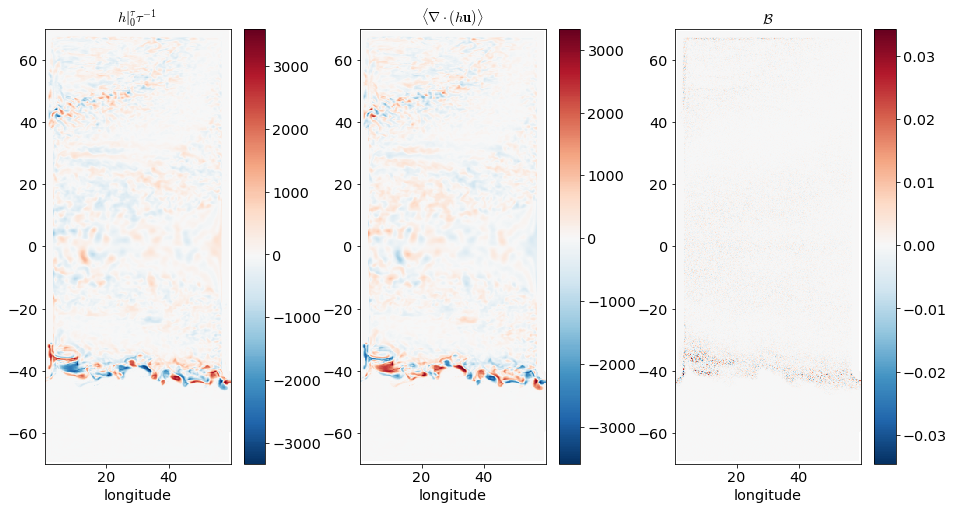

In [20]:
eqn3_budget = eqn3_term1 + eqn3_term2 

print(eqn3_term2.max()/eqn3_term1.min())

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(st.xh,st.yh,eqn3_term1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([st.xh.min(), st.xh.max(), st.yh.min(), st.yh.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$h \vert_0^\tau \tau^{-1}$')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(st.xh,st.yh,eqn3_term2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([st.xh.min(), st.xh.max(), st.yh.min(), st.yh.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$ \nabla\cdot \langle h\mathbf{u}\rangle $')
plt.title(r'$\langle \nabla\cdot (h\mathbf{u})\rangle $')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(st.xh,st.yh,eqn3_budget,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([st.xh.min(), st.xh.max(), st.yh.min(), st.yh.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{B}$')
plt.colorbar()
plt.savefig('EQN_3_B_layer_%i_start_time_%i_days_tau_%i_days.png' % (layer_no,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)

## Space-time averaged (equation 14-15)

In [21]:
# plt.figure(figsize=(16,16))
# plt.subplot(2,2,1)
# plt.pcolormesh(coarsen_hu(eqn3_term1)+coarsen_hu(eqn3_term2))
# plt.colorbar()
# plt.subplot(2,2,2)
# plt.pcolormesh(eqn3_term2)
# plt.colorbar()
# plt.subplot(2,2,3)
# plt.pcolormesh(coarsen_hu(eqn3_term1))
# plt.colorbar()
# plt.subplot(2,2,4)
# plt.pcolormesh(coarsen_hu(eqn3_term2))
# plt.colorbar()

In [22]:
grid = Grid(av, coords={'X': {'center': 'xh', 'outer': 'xq'},
                        'Y': {'center': 'yh', 'outer': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X'])

def interp_h_to_u(h):
    n,layers,ly,lx = h.shape
    h_at_u = np.zeros((n,layers,ly,lx+1))
    h_at_u[:,:,:,1:-1] = (h[:,:,:,:-1] + h[:,:,:,1:])/2
    h_at_u[:,:,:,0] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    h_at_u[:,:,:,-1] = (h[:,:,:,0] + h[:,:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    n,layers,ly,lx = h.shape
    h_at_v = np.zeros((n,layers,ly+1,lx))
    h_at_v[:,:,1:-1,:] = (h[:,:,:-1,:] + h[:,:,1:,:])/2
    h_at_v[:,:,0,:] = h[:,:,0,:] # non-periodic
    h_at_v[:,:,-1,:] = h[:,:,-1,:] # non-periodic
    
    return h_at_v

# h_at_u = grid.interp(av.h, axis='X',boundary='fill') # m
h_at_u = interp_h_to_u(av.h.values.astype(float)) # m
u_eff = (av.uh.astype(float))/(h_at_u + 1e-20) # m^2/s (multiply by st.dyCu to get the right units)
# hu_eddy = av.uh.mean(axis=0) - h_at_u.mean(axis=0)*u_eff.mean(axis=0)*st.dyCu

# h_at_v = grid.interp(av.h, axis='Y',boundary='fill') # m
h_at_v = interp_h_to_v(av.h.values.astype(float))
v_eff = (av.vh.astype(float))/(h_at_v + 1e-20) # m^2/s (multiply by st.dxCv to get the right units)
# hv_eddy = av.vh.mean(axis=0) - h_at_v.mean(axis=0)*v_eff.mean(axis=0)*st.dxCv

h_temp = av.h.sel(time=slice(start_time,end_time)).astype(float) # m
uh_temp = av.uh.sel(time=slice(start_time,end_time)).astype(float) # m^3/s
vh_temp = av.vh.sel(time=slice(start_time,end_time)).astype(float) # m^3/s
u_temp = u_eff.sel(time=slice(start_time,end_time)) # m^2/s
v_temp = v_eff.sel(time=slice(start_time,end_time)) # m^2/s

time = av.time.sel(time=slice(start_time,end_time)) 
h_fine = h_temp[:,layer_no] # m
uh_fine = uh_temp[:,layer_no] # m^3/s
vh_fine = vh_temp[:,layer_no] # m^3/s
u_fine = u_temp[:,layer_no] # m^2/s
v_fine = v_temp[:,layer_no] # m^2/s

In [23]:
def coarsen_h(h_fine):
    n,ly,lx = h_fine.shape 
    hc_coarse = np.zeros((n,ly//coarsen,lx//coarsen))
    
    # Coarsening h to hc_coarse
    for j in range(coarsen):
        for i in range(coarsen):
            hc_coarse[:,:,:] = hc_coarse[:,:,:] + h_fine[:,j::coarsen,i::coarsen]
    
    return hc_coarse/(coarsen**2)

def project_h_to_fine(h_coarse):
    n,ly_coarsen,lx_coarsen = h_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*lx_coarsen
    hc_fine = np.zeros((n,ly,lx))
    
    # Projecting hc_coarse onto the fine grid 
    for j in range(coarsen):
        for i in range(coarsen):
            hc_fine[:,j::coarsen,i::coarsen] = hc_coarse[:,:,:] 
   
    return hc_fine

def coarsen_u(u_fine):
    n,ly,lx_p_1 = u_fine.shape 
    lx = lx_p_1 - 1
    uc_coarse = np.zeros((n,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uc_coarse[:,:,:] = uc_coarse[:,:,:] + u_fine[:,j::coarsen,::coarsen]
    
    return uc_coarse/coarsen

def coarsen_hu(uh_fine):
    n,ly,lx_p_1 = uh_fine.shape 
    lx = lx_p_1 - 1
    uhc_coarse = np.zeros((n,ly//coarsen,lx//coarsen+1))
    
    # Coarsening uc to uc_coarse
    for j in range(coarsen):
        uhc_coarse[:,:,:] = uhc_coarse[:,:,:] + uh_fine[:,j::coarsen,::coarsen]
    
    return uhc_coarse

def project_u_to_fine(u_coarse):
    n,ly_coarsen,lx_coarsen_p_1 = u_coarse.shape 
    ly,lx = coarsen*ly_coarsen,coarsen*(lx_coarsen_p_1-1)
    uc_fine = np.zeros((n,ly,lx//coarsen+1))
    
    # Projecting onto the fine grid 
    for j in range(coarsen):
        uc_fine[:,j::coarsen,:] = u_coarse[:,:,:]
        
    return uc_fine

def coarsen_v(v_fine):
    n,ly_p_1,lx = v_fine.shape 
    ly = ly_p_1 - 1
    vc_coarse = np.zeros((n,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vc_coarse[:,:,:] = vc_coarse[:,:,:] + v_fine[:,::coarsen,i::coarsen]
    
    return vc_coarse/coarsen

def coarsen_hv(vh_fine):
    n,ly_p_1,lx = vh_fine.shape 
    ly = ly_p_1 - 1
    vhc_coarse = np.zeros((n,ly//coarsen+1,lx//coarsen))
    
    # Coarsening uc to uc_coarse
    for i in range(coarsen):
        vhc_coarse[:,:,:] = vhc_coarse[:,:,:] + vh_fine[:,::coarsen,i::coarsen]
    
    return vhc_coarse

def project_v_to_fine(v_coarse):
    n,ly_coarsen_p_1,lx_coarsen = v_coarse.shape 
    ly,lx = coarsen*(ly_coarsen_p_1-1),coarsen*lx_coarsen
    vc_fine = np.zeros((n,ly//coarsen+1,lx))
    
    # Projecting onto the fine grid 
    for i in range(coarsen):
        vc_fine[:,:,i::coarsen] = v_coarse[:,:,:]
        
    return vc_fine

def interp_h_to_u(h):
    n,ly,lx = h.shape
    h_at_u = np.zeros((n,ly,lx+1))
    h_at_u[:,:,1:-1] = (h[:,:,:-1] + h[:,:,1:])/2
    h_at_u[:,:,0] = (h[:,:,0] + h[:,:,-1])/2 # periodic
    h_at_u[:,:,-1] = (h[:,:,0] + h[:,:,-1])/2 # periodic
    
    return h_at_u
    
def interp_h_to_v(h):
    n,ly,lx = h.shape
    h_at_v = np.zeros((n,ly+1,lx))
    h_at_v[:,1:-1,:] = (h[:,:-1,:] + h[:,1:,:])/2
    h_at_v[:,0,:] = h[:,0,:] # non-periodic
    h_at_v[:,-1,:] = h[:,-1,:] # non-periodic
    
    return h_at_v
    
def calc_hc_uc(hc,uc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    uc_fine = project_u_to_fine(uc_coarse)
    
    return h_at_u[:,:,::coarsen]*uc_fine

def calc_hc_up(hc_coarse,up):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_u = interp_h_to_u(hc_fine)
    
    return h_at_u[:,:,::coarsen]*up

def calc_hp_uc(hp,uc_coarse):
    uc_fine = project_u_to_fine(uc_coarse)
    h_at_u = interp_h_to_u(hp)
    
    return h_at_u[:,:,::coarsen]*uc_fine

def calc_hp_up(hp,up):
    h_at_u = interp_h_to_u(hp)
    
    return h_at_u[:,:,::coarsen]*up

def calc_hc_vc(hc,vc):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_v = interp_h_to_v(hc_fine)
    vc_fine = project_v_to_fine(vc_coarse)
    
    return h_at_v[:,::coarsen,:]*vc_fine

def calc_hc_vp(hc_coarse,vp):
    hc_fine = project_h_to_fine(hc_coarse)
    h_at_v = interp_h_to_v(hc_fine)
    
    return h_at_v[:,::coarsen,:]*vp

def calc_hp_vc(hp,vc_coarse):
    vc_fine = project_v_to_fine(vc_coarse)
    h_at_v = interp_h_to_v(hp)
    
    return h_at_v[:,::coarsen,:]*vc_fine

def calc_hp_vp(hp,vp):
    h_at_v = interp_h_to_v(hp)
    
    return h_at_v[:,::coarsen,:]*vp


hc_coarse = coarsen_h(h_fine)
hc_fine = project_h_to_fine(hc_coarse)
hp_fine = h_fine - hc_fine

uc_coarse = coarsen_u(u_fine)
uc_fine = project_u_to_fine(uc_coarse)
up_fine = u_fine[:,:,::coarsen] - uc_fine

uhc_coarse = coarsen_hu(uh_fine)
uhc_fine = project_u_to_fine(uhc_coarse)

vc_coarse = coarsen_v(v_fine)
vc_fine = project_v_to_fine(vc_coarse)
vp_fine = v_fine[:,::coarsen,:] - vc_fine

vhc_coarse = coarsen_hv(vh_fine)
vhc_fine = project_v_to_fine(vhc_coarse)

hcuc_semi_fine = calc_hc_uc(hc_coarse,uc_coarse)
hcup_semi_fine = calc_hc_up(hc_coarse,up_fine)
hpuc_semi_fine = calc_hp_uc(hp_fine.values,uc_coarse)
hpup_semi_fine = calc_hp_up(hp_fine.values,up_fine)

hcvc_semi_fine = calc_hc_vc(hc_coarse,vc_coarse)
hcvp_semi_fine = calc_hc_vp(hc_coarse,vp_fine)
hpvc_semi_fine = calc_hp_vc(hp_fine.values,vc_coarse)
hpvp_semi_fine = calc_hp_vp(hp_fine.values,vp_fine)

def sum_j_direction(hu):
    n,ly,lx_p_1 = hu.shape 
    lx = lx_p_1 - 1
    hu_coarse = np.zeros((n,ly//coarsen,lx+1))
    
    for j in range(coarsen):
        hu_coarse[:,:,:] = hu_coarse[:,:,:] + hu[:,j::coarsen,:]
    
    return hu_coarse

def sum_i_direction(hv):
    n,ly_p_1,lx = hv.shape 
    ly = ly_p_1 - 1
    hv_coarse = np.zeros((n,ly+1,lx//coarsen))
    
    for i in range(coarsen):
        hv_coarse[:,:,:] = hv_coarse[:,:,:] + hv[:,:,i::coarsen]
    
    return hv_coarse


hcup = sum_j_direction(hcup_semi_fine)
hpuc = sum_j_direction(hpuc_semi_fine)
hpup = sum_j_direction(hpup_semi_fine)
hcuc = sum_j_direction(hcuc_semi_fine)

hcvp = sum_i_direction(hcvp_semi_fine)
hpvc = sum_i_direction(hpvc_semi_fine)
hpvp = sum_i_direction(hpvp_semi_fine)
hcvc = sum_i_direction(hcvc_semi_fine)

hdagudag_fine = uh_fine.values - interp_h_to_u(h_fine.values)*u_fine.values
hdagvdag_fine = vh_fine.values - interp_h_to_v(h_fine.values)*v_fine.values

hdagudag = coarsen_hu(hdagudag_fine)
hdagvdag = coarsen_hv(hdagvdag_fine)

ly,lx = st.area_t.shape
areac = st.area_t.values.reshape((ly//coarsen,coarsen,lx//coarsen,coarsen)).sum(axis=-1).sum(axis=1)

In [24]:
# a = uh_fine[0].values
# b = calc_hc_uc(h_fine.values,u_fine.values)
# b = b[0]

# plt.pcolormesh(st.xq,st.yh,a-b,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
# plt.xlabel('longitude')
# plt.ylabel('latitude')
# plt.axis([st.xq.min(), st.xq.max(), st.yh.min(), st.yh.max()])
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar()

# np.nanmax(abs(a-b))/np.nanmax(abs(a))

In [25]:
xhc = st.xh.values.reshape(-1,coarsen).mean(axis=1)
yhc = st.yh.values.reshape(-1,coarsen).mean(axis=1)
xqc = st.xq.values[::coarsen]
yqc = st.yq.values[::coarsen]

dsc = xr.Dataset(coords={'xhc': (['xhc',], xhc), 'xqc': (['xqc',], xqc), 'yhc': (['yhc',], yhc), 'yqc': (['yqc',], yqc), 'time': (['time',], time)})
dsc = dsc.assign_coords({'xhc': ('xhc', xhc), 'xqc': ('xqc', xqc), 'yhc': ('yhc', yhc), 'yqc':('yqc', yqc), 'time':('time',time) }) 
gridc = Grid(dsc, coords={'X': {'center': 'xhc', 'outer': 'xqc'},
                          'Y': {'center': 'yhc', 'outer': 'yqc'} }, periodic=['X'])

dsc = xr.Dataset({'hcuc': (('time','yhc','xqc'), hcuc), 
                  'hcup': (('time','yhc','xqc'), hcup), 
                  'hpuc': (('time','yhc','xqc'), hpuc), 
                  'hpup': (('time','yhc','xqc'), hpup), 
                  'hdagudag': (('time','yhc','xqc'), hdagudag), 
                  'uhc_coarse': (('time','yhc','xqc'), uhc_coarse), 
                  'hcvc': (('time','yqc','xhc'), hcvc), 
                  'hcvp': (('time','yqc','xhc'), hcvp), 
                  'hpvc': (('time','yqc','xhc'), hpvc), 
                  'hpvp': (('time','yqc','xhc'), hpvp), 
                  'hdagvdag': (('time','yqc','xhc'), hdagvdag),
                  'vhc_coarse': (('time','yqc','xhc'), vhc_coarse), 
                  'areac': (('yhc','xhc'), areac)})

In [26]:
term2_temp =  (gridc.diff(dsc.hcuc.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hcvc.astype(float), 'Y', boundary='fill')) 
term2 = term2_temp.mean(axis=0)
term2_uhc = (gridc.diff(dsc.uhc_coarse, 'X', boundary='fill') + gridc.diff(dsc.vhc_coarse, 'Y', boundary='fill'))
term2_uhc = (term2_uhc).mean(axis=0)
np.shape(term2)

/glade/u/apps/dav/opt/python/3.7.5/gnu/8.3.0/pkg-library/20200417/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(280, 120)

In [27]:
term3_temp =  (gridc.diff(dsc.hcup.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hcvp.astype(float), 'Y', boundary='fill')) 
term3 = term3_temp.mean(axis=0)
np.shape(term3)

(280, 120)

In [28]:
term4_temp =  (gridc.diff(dsc.hpuc.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hpvc.astype(float), 'Y', boundary='fill')) 
term4 = term4_temp.mean(axis=0)
np.shape(term4)

(280, 120)

In [29]:
term5_temp =  (gridc.diff(dsc.hpup.astype(float), 'X', boundary='fill') + gridc.diff(dsc.hpvp.astype(float), 'Y', boundary='fill')) 
term5 = term5_temp.mean(axis=0)
np.shape(term5)

(280, 120)

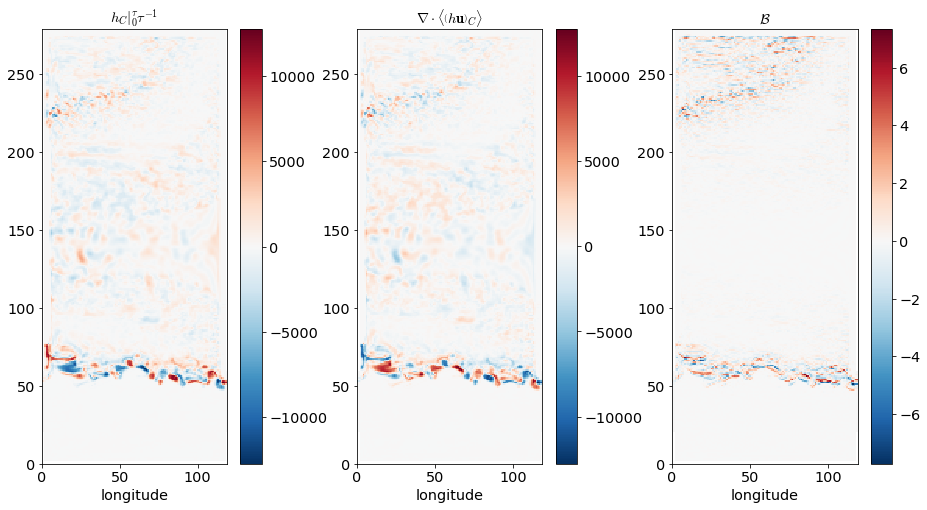

In [30]:
budget = term1 + term2_uhc

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(dsc.xhc,dsc.yhc,term1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$h_C \vert_0^\tau \tau^{-1}$')
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(dsc.xhc,dsc.yhc,term2_uhc,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot \langle \left(h \mathbf{u}\right)_C \rangle $')
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(dsc.xhc,dsc.yhc,budget,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{B}$')
plt.colorbar()
plt.savefig('EQN_14_B_coarsen_%i_layer_%i_start_time_%i_days_tau_%i_days.png' % (coarsen,layer_no,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)
plt.show()

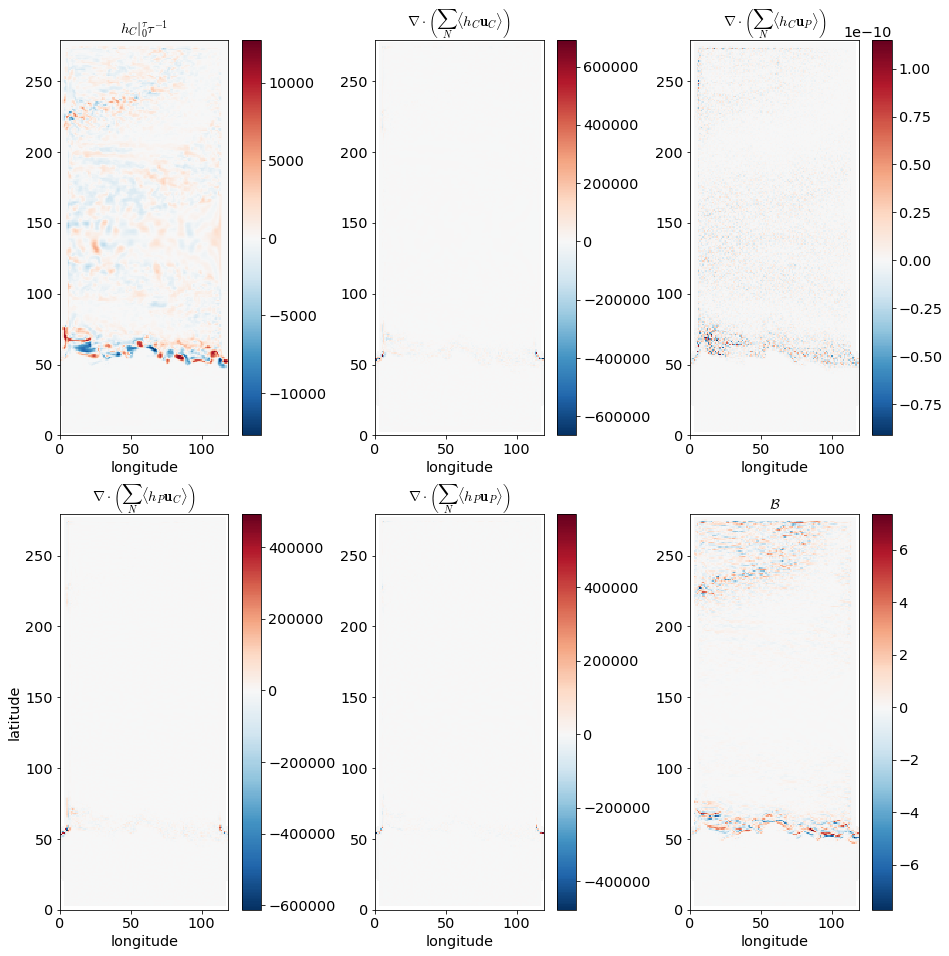

In [31]:
budget = term1 + term2 + term3 + term4 + term5 

plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
plt.pcolormesh(dsc.xhc,dsc.yhc,term1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$h_C \vert_0^\tau \tau^{-1}$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(dsc.xhc,dsc.yhc,term2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_C \mathbf{u}_C \rangle\right) $')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(dsc.xhc,dsc.yhc,term3,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_C \mathbf{u}_P \rangle\right)$')
plt.colorbar()

plt.subplot(2,3,4)
plt.pcolormesh(dsc.xhc,dsc.yhc,term4,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot \left( \sum_{N} \langle h_P \mathbf{u}_C \rangle \right) $')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(dsc.xhc,dsc.yhc,term5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\sum_{N}\langle h_P \mathbf{u}_P \rangle\right)$')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(dsc.xhc,dsc.yhc,budget,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{B}$')
plt.colorbar()
plt.savefig('EQN_15_B_coarsen_%i_layer_%i_start_time_%i_days_tau_%i_days.png' % (coarsen,layer_no,start_time,tau/86400), dpi=200,bbox_inches='tight',pad_inches=0)
plt.show()

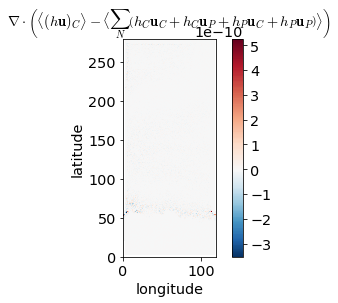

In [32]:
temp_var = term2_uhc-term2-term3-term4-term5

plt.pcolormesh(dsc.xhc,dsc.yhc,temp_var,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.axis([dsc.xhc.min(), dsc.xhc.max(), dsc.yhc.min(), dsc.yhc.max()])
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\nabla\cdot\left(\langle (h \mathbf{u})_C \rangle -\langle \sum_{N} \left(h_C \mathbf{u}_C + h_C \mathbf{u}_P + h_P \mathbf{u}_C +h_P \mathbf{u}_P\right) \rangle\right) $')
plt.colorbar()
plt.savefig('difference.png', dpi=200,bbox_inches='tight',pad_inches=0)